# Simulações de Monte Carlo

O **alto nível de insegurança** nos mercados financeiros tornam as simulações de **Monte Carlo** uma **ferramenta valiosa** quando estamos tentando realizar uma **tomada de decisão.** <br><br>

**Mas por que?** <br><br>

Primeiramente temos que pensar o seguinte: **tudo que acontece na vida é apenas uma das diferentes possibilidades de realização de um evento**. <br><br>

Tomemos como exemplo o evento de um jogador de basquete estar arremessando um lance livre, e concordamos que ele pode tanto acertar quanto errar. Se você estiver observando este evento, e nunca tiver visto o jogador em questão, poderá chutar que há 50% de chances de ele acertar o lance livre. Agora, se você for um fã de basquete, e ver que o Shaquille O'Neal irá arremessar o lance livre, saberá que a probabilidade diz que ele não acertará, porque você conhece dados históricos que dizem que ele erra mais lances livres do que acerta. Agora, se você estiver vendo o Stephen Curry arremessar um lance livre, provavelmente me dirá que ele vai acertar, porque, conhecendo os dados históricos, sabe que a probabilidade nos diz que ele acertou muito mais lances livres do que já errou na vida.

Trouxe esse exemplo para fazer um paralelo com o funcionamento das simulações de Monte Carlo. O que a simulação faz é, baseando-se em dados históricos, utilizar esses dados como proxy para simular realizações de eventos futuros, criando assim uma séria fictícia a respeito do futuro, porém com uma relativamente boa base histórica por trás apoiando a nossa simulação.

**Mas o que de fato é uma simulação de Monte Carlo?**

Uma simulação de Monte Carlo é uma simulação de *evolução aleatória*. Ou seja, o que faremos é basicamente uma série de iterações, com base em nossos dados amostrais, de evoluções aleatória desses dados, e com base na análise dessas evoluções, iremos tentar fazer importantes inferências.

Isso pode não ter sido extremamente claro, mas espero que se torne mais tangível um pouco mais a frrente quando a gente de fato fizer o código em Python.

Para a gente fazer essa estimação aleatória, é útil que tomemos alguma *função de densidade de probabilidade* (FDP) como parâmetro (caso não esteja nem um pouco familiarizado com o assunto, indico que pesquise mais a respeito), e, neste caso para simulações do mundo financeiro, a distribuição *gaussiana* ou também conhecida como distribuição normal, é bem comum e será a FDP utilizada nos nossos códigos.

## Vamos ao código:

Para tudo ficar mais claro, vamos fazer aqui um exemplo que vou tentar simplificar ao máximo e ir explicando o passo a passo...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Primeiro, o que vou fazer é criar uma série temporal fictícia, e vamos fingir que essa série temporal represente a evolução (em milhões de reais) da receita de uma empresa. Vou colocar essa série num array chamado `receitas`. Para mais informações de como gerar séries temporais fictícias veja [aqui!](https://towardsdatascience.com/time-series-analysis-creating-synthetic-datasets-cf008208e014)

In [2]:
# Array de receitas (valores em milhões)

receitas = np.random.randn(100) + np.arange(5,20,0.15)

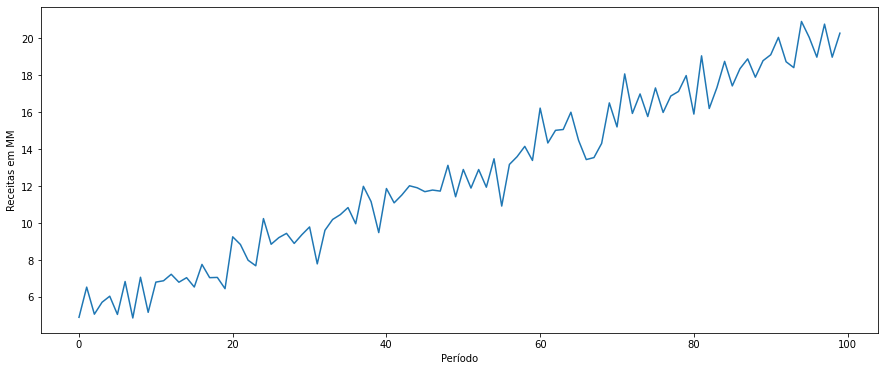

In [3]:
# Essas são as nossas receitas fictícias:

plt.figure(figsize=(15,6))
plt.plot(receitas)
plt.xlabel('Período')
plt.ylabel('Receitas em MM')
plt.show()

O que fiz agora foi criar as receitas fictícias de uma empresa em pleno crescimento. Entenda o gráfico acima como a evolução de receitas da nossa empresa por 100 períodos!

O que faremos será utilizar a simulação de Monte Carlo para projetar as receitas dos próximos 50 períodos! Mas primeiro, vamos analisar um pouco mais os dados da nossa série temporal...

## Análise dos dados:

Primeiro, quero um array que tenha apenas a taxa de crescimento da receita entre um período e o próximo:

In [4]:
# tc = taxa de crescimento
# criando um array que armazena a taxa de crescimento entre um período e outro


tc = (pd.Series(receitas) / pd.Series(receitas).shift(1)) - 1

Agora que temos um array com as nossas taxas de crescimento, vamos plotá-las em um histograma para ter uma ideia de como essas taxas estão distribuídas.

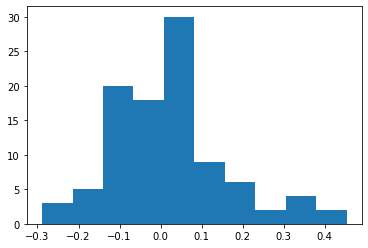

In [16]:
# Plotando aqui a nossa taxa de crescimento das receitas, deve seguir algo próximo a uma gaussiana:

plt.figure()
plt.hist(tc, bins = 10)
plt.show()

Para efeitos de simplificação, vamos assumir (com um certo grau de conforto, observando o gráfico) que a nossa distribuição das taxas possa ser precisamente representada por uma normal! Para aplicações práticas e mais robustas, testes de hipótese (ex.: Shapiro-Wilk) e validações maiores são recomendadas.

In [6]:
taxa_media = tc.mean() # A média das taxas
taxa_desvpad = tc.std() # O desvio padrão das taxas

O que temos até o momento é uma ideia de qual a distribuição que nossas taxas possuem (gaussiana, ou, comumente chamada de normal), a taxa média e o desvio padrão das taxas, que são os parâmetros que vão nos permitir modelar possibilidades de *continuações* para as nossas séries de receitas!

Agora que temos esses parâmetros, que são fundamentais para realizarmos as modelagens, podemos de fato iniciar a rodar uma simulação de Monte Carlo!

## Simulação:

Primeiro, vamos definir quantas simulações vamos rodar, e, em cada uma dessas simulações, quantos períodos iremos rodar:

In [60]:
num_simula = 500 # Quantidade de simulações que vamos rodar
num_per = 50 # Número de períodos que cda simulação irá possuir

A simulação de Monte Carlo é útil porque, com base na distribuição de nossas taxas, iremos rodar diversas "possibilidades", que são as nossas simulações, e esperamos que uma média entre essas diversas simulações, possa nos dar uma representação minimamente semelhante à o que acontecerá na realidade!

In [61]:
sim_df = pd.DataFrame() # Definindo um DF para armazenar os dados de nossas simulações

O bloco de código abaixo irá conter o que de fato consiste na nossa simulação. Vou tentar comentar esta seção ao máximo e explicar o que eu fiz no máximo detalhe possível!

In [62]:
for x in range(num_simula): # Criando o primeiro loop que rodará as simulações
    
    y = 0
    
    serie_modelada = [] # Lista para armazenar os valores da atual simulação
    
    primeiro_periodo = receitas[-1] * (1 + np.random.normal(loc=taxa_media, scale=taxa_desvpad)) 
    # O primeiro período da atual simulação, levando em consideração o último período real
    
    serie_modelada.append(primeiro_periodo) # Apendo o valor do primeiro período no array da atual simulação
    
    for y in range(num_per): # Neste loop eu vou criando os demais períodos da atual simulação
        
        if y == num_per-1:
            break # Por conta do zero indexing, na verdade rodamos o loop pelo número de perídos menos uma vezes.
        
        periodo_atual = serie_modelada[y] * (1 + np.random.normal(loc=taxa_media, scale=taxa_desvpad))
        # Calculando o valor do período atual para cada iteração do loop
        
        serie_modelada.append(periodo_atual) # Adicionando esse valor a nossa simulação atual
        
    sim_df[x] = serie_modelada # Crio uma coluna no dataframe com a atual simulação    

Bom, vamos falar com um pouco mais de calma sobre o que fizemos acima... <br><br>

A nossa simulação é composta por dois `for loops`, ou, o que chamam também de *nested loops*. Sendo que o primeiro loop rodará pelo número de simulações, e dentro de cada simulação, iremos rodar a quantidade de períodos.

E, o passo a passo do processo funciona da seguinte maneira:

- Primeiro criamos o loop para cada simulação, dentro desse primeiro loop, definimos as variáveis `y`, que funciona como um *counter* dos nossos períodos, ou seja, deve ser resetada para todas as novas simulações, e um array vazio que armazenará os valores da nossa série modelada (para a atual simulação)
- Além disso, nesse primeiro `for loop` também calculamos o valor do primeiro período da nossa modelagem, sendo que este será igual ao valor do último período da nossa série temporal, vezes um valor aleatório
    - Este valor aleatório é gerado da seguinte maneira: é um valor aleatório com base em uma distribuição normal de média igual à média de nossa taxa de crescimento e com desvio padrão igual ao desvio padrão de nossa taxa de crescimento! É exatamente assim que garantimos que nossa simulação de Monte Carlo possuirá um certo grau de acurácia, porque estamos gerando os valores aleatórios com base em uma distribuição com a qual as nossas taxas de crescimento se aproximam!
- Depois de calcular o valor do primeiro período, eu insiro esse valor na nossa variável `serie_modelada`, que até eu dar este comando, era um array vazio! <br><br>

Esses acima são os comandos do nosso primeiro `for loop`, depois disso, dentro desse loop, criamos um outro *nested loop*, que irá simular os valores de cada um dos períodos:

- Nesse loop, eu rodo ele pela quantidade de períodos - 1, o menos 1 existe por conta do *0 indexing* do Python, ou seja, se rodarmos o nosso loop por um range de 30, rodaremos 31 simulações, portanto, para rodar 30 períodos, coloco um *if statement* dando o comando de `break` caso atinjamos o valor de `num_per-1` para o nossa variável `y` que possui papel de *counter*!
- Para cada iteração do loop, calculamos o valor de uma nova receita, multiplicando o valor do período anterior por uma taxa de crescimento aleatória (com base na mesma distribuição normal!)
- Depois de calcular o valor da receita, insiro no array de `serie_modelada` e sigo rodando os próximos períodos...<br><br>

Ao terminar de rodar todos os períodos, eu coloco essa série modelada em uma coluna de um DataFrame, e sigo rodando as próximas simulações...

Ao final do processo, obtemos o seguinte DF...

In [53]:
sim_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,19.686741,18.465984,20.287945,20.269475,19.578292,16.666202,18.764323,17.544894,21.249608,17.191738,...,20.117716,21.391814,20.364215,17.217969,19.386184,23.576226,22.312077,21.969506,20.531710,18.627441
1,18.756452,16.731526,19.402807,21.731673,16.008048,17.551930,15.584564,15.898424,22.219722,15.867462,...,18.730212,16.965786,19.861201,18.447778,19.115389,21.615274,27.230130,19.966419,27.117068,19.656433
2,18.839087,17.367380,18.886788,22.635753,16.231144,19.411838,18.819157,18.137954,24.803745,14.571139,...,17.621310,17.626808,23.252209,10.710556,19.266778,24.091356,35.729524,19.708981,26.330505,19.504354
3,21.736468,14.794783,23.374361,23.753079,20.703802,22.004847,17.755652,13.328482,30.041820,15.732985,...,16.925319,15.600746,23.617782,10.460191,16.785858,28.756489,33.320830,20.816465,28.719280,24.115122
4,20.821225,14.549321,23.969338,23.787616,22.281396,22.039203,20.339664,12.241896,27.971817,17.315754,...,12.635822,15.164614,20.570252,10.628042,15.856449,31.117903,32.675413,24.408303,29.863552,27.191928
5,24.673357,12.781184,21.659826,13.884290,28.355093,17.065333,22.573506,12.358014,30.299102,16.191464,...,12.073361,13.935968,23.661661,10.429160,16.314677,39.324816,29.300695,29.128293,18.895845,25.252859
6,27.884666,15.127328,17.144943,14.029721,30.929063,16.768552,25.704233,10.217420,26.992165,19.028249,...,10.813161,19.975630,24.440085,9.992683,14.698668,53.387178,24.744464,19.550459,17.980968,23.848408
7,26.679455,17.927904,14.806179,14.638948,35.592639,13.263601,25.314466,11.438451,24.930544,17.533986,...,10.803922,19.533770,25.958205,10.647330,13.762796,46.870733,25.315307,24.374105,18.790279,25.144301
8,14.066003,22.070423,13.217831,16.677613,42.294116,12.481464,18.859625,10.971781,21.580680,14.453048,...,14.224398,22.527826,28.745426,8.545812,11.101054,55.996648,31.186323,28.085051,14.443606,27.325189
9,12.586030,18.207688,15.226050,15.254643,38.894098,11.730487,20.122638,12.676461,22.100504,16.747341,...,12.952982,20.305193,17.913196,10.639530,10.966366,55.901281,29.418661,23.284230,14.175347,23.469254


No DF acima, cada coluna se refere à uma simulação, e cada linha se refere a um período!

Ao plotar nossas simulações, obtemos o seguinte:

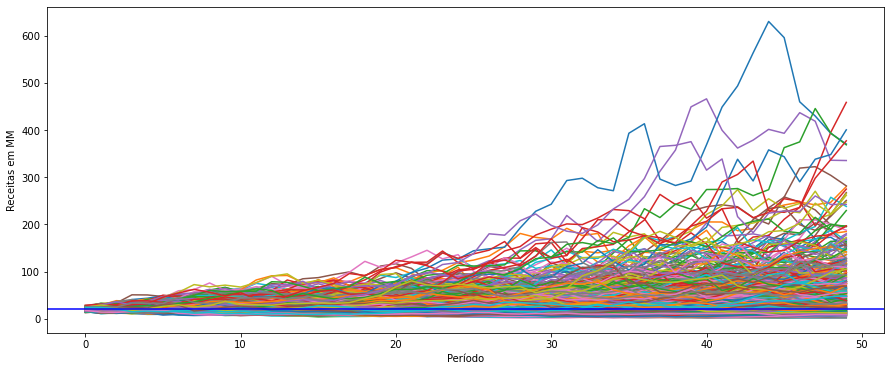

In [63]:
plt.figure(figsize=(15,6))
plt.plot(sim_df)
plt.axhline(y=receitas[-1], color='b', linestyle='-') #Linha azul é referente ao último valor real
plt.xlabel('Período')
plt.ylabel('Receitas em MM')
plt.show()

Posso pegar uma série qualquer, só para darmos uma olhada em uma simulação qualquer:

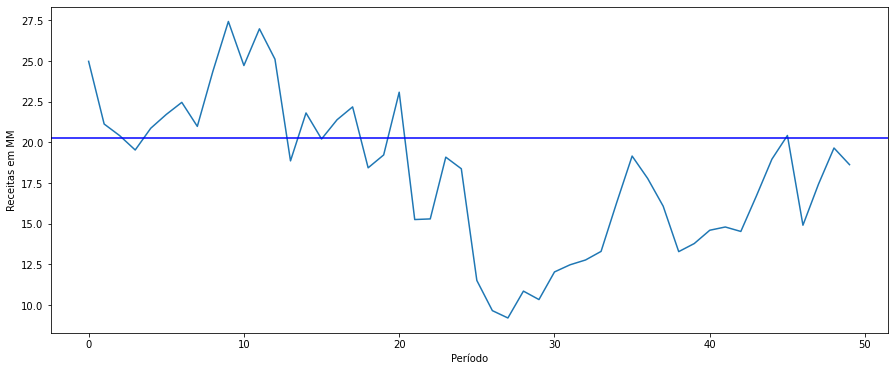

In [55]:
plt.figure(figsize=(15,6))
plt.plot(sim_df[20])
plt.axhline(y=receitas[-1], color='b', linestyle='-')
plt.xlabel('Período')
plt.ylabel('Receitas em MM')
plt.show()

Mas, possivelmente mais interessante, podemos criar uma coluna no DF com a média de todas as simulações, e ver o que obtemos a partir disso:

In [56]:
sim_df['media'] = sim_df.mean(axis=1)

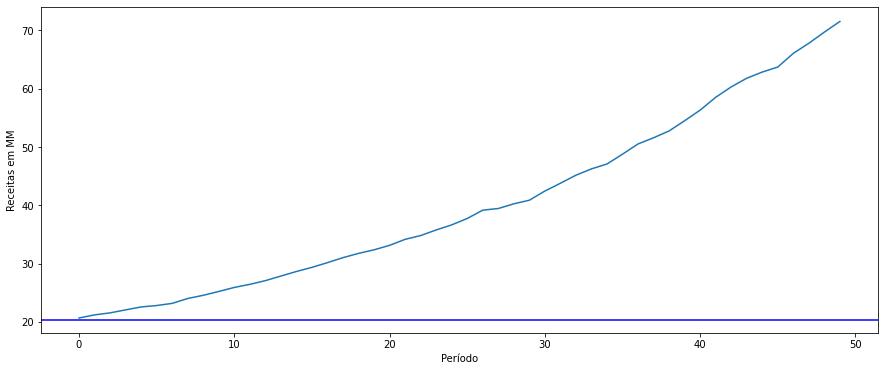

In [57]:
plt.figure(figsize=(15,6))
plt.plot(sim_df['media'])
plt.axhline(y=receitas[-1], color='b', linestyle='-')
plt.xlabel('Período')
plt.ylabel('Receitas em MM')
plt.show()

Veja que interessante!

Criado por: <br><br>

Reddit: **u_jvsm**